<a href="https://colab.research.google.com/github/prakhar-luke/customer_churn_pred/blob/main/churn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import libs and dependencies

In [1]:
#import the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN

# 1. Load the Data

In [3]:
df = pd.read_excel("/content/drive/MyDrive/MY_dataset/customer_churn_large_dataset.xlsx")

In [4]:
df.sample(4)

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
92666,92667,Customer_92667,28,Female,Miami,20,90.69,423,1
18958,18959,Customer_18959,38,Male,Houston,1,79.92,415,1
41810,41811,Customer_41811,48,Female,Miami,9,46.58,337,0
69716,69717,Customer_69717,33,Female,Los Angeles,19,68.26,454,0


In [5]:
df.shape

(100000, 9)

# 2. EDA

In [6]:
df.columns.values

array(['CustomerID', 'Name', 'Age', 'Gender', 'Location',
       'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB',
       'Churn'], dtype=object)

In [7]:
df.dtypes

CustomerID                      int64
Name                           object
Age                             int64
Gender                         object
Location                       object
Subscription_Length_Months      int64
Monthly_Bill                  float64
Total_Usage_GB                  int64
Churn                           int64
dtype: object

In [8]:
df.describe()

,CustomerID,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,44.027020,12.490100,65.053197,274.393650,0.497790
std,28867.657797,15.280283,6.926461,20.230696,130.463063,0.499998
min,1.000000,18.000000,1.000000,30.000000,50.000000,0.000000
25%,25000.750000,31.000000,6.000000,47.540000,161.000000,0.000000
50%,50000.500000,44.000000,12.000000,65.010000,274.000000,0.000000
75%,75000.250000,57.000000,19.000000,82.640000,387.000000,1.000000
max,100000.000000,70.000000,24.000000,100.000000,500.000000,1.000000


In [9]:
# Drop Name column
df.drop('Name', axis='columns', inplace=True)

In [10]:
# Conver Female/Male to 0/1
df['Gender'] = df['Gender'].map({'Female':0, 'Male':1})

In [11]:
# One-hot encode Location
df2 = pd.get_dummies(data=df, columns=['Location'])
df2.columns

Index(['CustomerID', 'Age', 'Gender', 'Subscription_Length_Months',
       'Monthly_Bill', 'Total_Usage_GB', 'Churn', 'Location_Chicago',
       'Location_Houston', 'Location_Los Angeles', 'Location_Miami',
       'Location_New York'],
      dtype='object')

In [12]:
def get_num_people_by_age_category(df):
    df2["age_group"] = pd.cut(x=df2['Age'], bins=[0,24,59,100], labels=["young","middle_aged","old"])
    return df

# Call function
df2 = get_num_people_by_age_category(df2)

In [13]:
df2.head()

,CustomerID,Age,Gender,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,age_group
0,1,63,1,17,73.36,236,0,0,0,1,0,0,old
1,2,62,0,1,48.76,172,0,0,0,0,0,1,old
2,3,24,0,5,85.47,460,0,0,0,1,0,0,young
3,4,36,0,3,97.94,297,1,0,0,0,1,0,middle_aged
4,5,46,0,19,58.14,266,0,0,0,0,1,0,middle_aged


In [14]:
# One-hot encode age_group
df3 = pd.get_dummies(data=df2, columns=['age_group'])
df3.columns

Index(['CustomerID', 'Age', 'Gender', 'Subscription_Length_Months',
       'Monthly_Bill', 'Total_Usage_GB', 'Churn', 'Location_Chicago',
       'Location_Houston', 'Location_Los Angeles', 'Location_Miami',
       'Location_New York', 'age_group_young', 'age_group_middle_aged',
       'age_group_old'],
      dtype='object')

In [15]:
df3.head()

,CustomerID,Age,Gender,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,age_group_young,age_group_middle_aged,age_group_old
0,1,63,1,17,73.36,236,0,0,0,1,0,0,0,0,1
1,2,62,0,1,48.76,172,0,0,0,0,0,1,0,0,1
2,3,24,0,5,85.47,460,0,0,0,1,0,0,1,0,0
3,4,36,0,3,97.94,297,1,0,0,0,1,0,0,1,0
4,5,46,0,19,58.14,266,0,0,0,0,1,0,0,1,0


In [16]:
# add total_bill (monthly sub * monthly bill)
df3.insert(4, "Total_Bill", df3.Monthly_Bill*df3.Subscription_Length_Months, True)

In [17]:
df3.head()

,CustomerID,Age,Gender,Subscription_Length_Months,Total_Bill,Monthly_Bill,Total_Usage_GB,Churn,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,age_group_young,age_group_middle_aged,age_group_old
0,1,63,1,17,1247.12,73.36,236,0,0,0,1,0,0,0,0,1
1,2,62,0,1,48.76,48.76,172,0,0,0,0,0,1,0,0,1
2,3,24,0,5,427.35,85.47,460,0,0,0,1,0,0,1,0,0
3,4,36,0,3,293.82,97.94,297,1,0,0,0,1,0,0,1,0
4,5,46,0,19,1104.66,58.14,266,0,0,0,0,1,0,0,1,0


In [18]:
# add total_bill : total_data_used
df3.insert(6, "cost_per_GB", df3.Total_Bill/df3.Total_Usage_GB, True)

In [19]:
df3.head()

,CustomerID,Age,Gender,Subscription_Length_Months,Total_Bill,Monthly_Bill,cost_per_GB,Total_Usage_GB,Churn,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,age_group_young,age_group_middle_aged,age_group_old
0,1,63,1,17,1247.12,73.36,5.284407,236,0,0,0,1,0,0,0,0,1
1,2,62,0,1,48.76,48.76,0.283488,172,0,0,0,0,0,1,0,0,1
2,3,24,0,5,427.35,85.47,0.929022,460,0,0,0,1,0,0,1,0,0
3,4,36,0,3,293.82,97.94,0.989293,297,1,0,0,0,1,0,0,1,0
4,5,46,0,19,1104.66,58.14,4.152857,266,0,0,0,0,1,0,0,1,0


## check if data is balanced or not

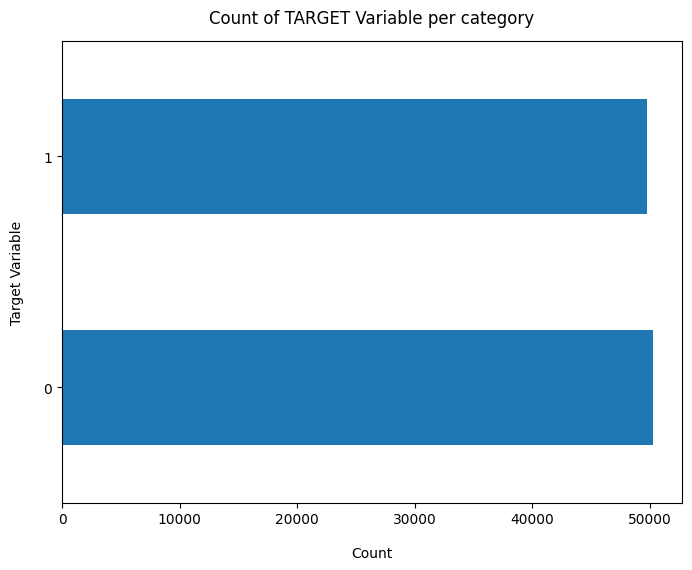

In [20]:
df3['Churn'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)
plt.title("Count of TARGET Variable per category", y=1.02);

In [21]:
100*df3['Churn'].value_counts()/len(df3['Churn'])

0    50.221
1    49.779
Name: Churn, dtype: float64

In [36]:
# Data is balanced

In [22]:
# Concise Summary of the dataframe, as we have too many columns, we are using the verbose = True mode
df3.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CustomerID                  100000 non-null  int64  
 1   Age                         100000 non-null  int64  
 2   Gender                      100000 non-null  int64  
 3   Subscription_Length_Months  100000 non-null  int64  
 4   Total_Bill                  100000 non-null  float64
 5   Monthly_Bill                100000 non-null  float64
 6   cost_per_GB                 100000 non-null  float64
 7   Total_Usage_GB              100000 non-null  int64  
 8   Churn                       100000 non-null  int64  
 9   Location_Chicago            100000 non-null  uint8  
 10  Location_Houston            100000 non-null  uint8  
 11  Location_Los Angeles        100000 non-null  uint8  
 12  Location_Miami              100000 non-null  uint8  
 13  Location_New Yo

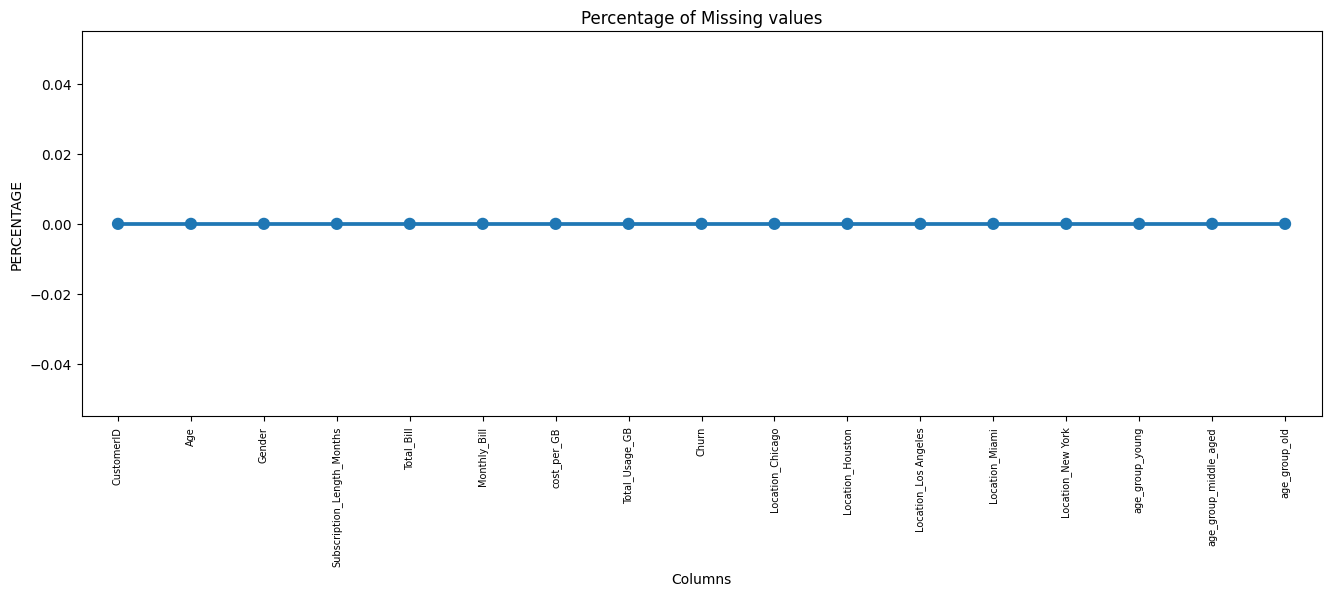

In [23]:
missing = pd.DataFrame((df3.isnull().sum()) * 100 / df3.shape[0]).reset_index()
plt.figure(figsize=(16, 5))
ax = sns.pointplot(x='index', y=0, data=missing)
plt.xticks(rotation=90, fontsize=7)
plt.title("Percentage of Missing values")
plt.ylabel("PERCENTAGE")
plt.xlabel("Columns")  # Add x-axis label
plt.show()

In [42]:
# no missing values

# 3. Data Cleaning

In [24]:
churn_data = df3.copy()

In [25]:
# check for missing values
churn_data.isnull().sum()

CustomerID                    0
Age                           0
Gender                        0
Subscription_Length_Months    0
Total_Bill                    0
Monthly_Bill                  0
cost_per_GB                   0
Total_Usage_GB                0
Churn                         0
Location_Chicago              0
Location_Houston              0
Location_Los Angeles          0
Location_Miami                0
Location_New York             0
age_group_young               0
age_group_middle_aged         0
age_group_old                 0
dtype: int64

In [26]:
churn_data.head()

,CustomerID,Age,Gender,Subscription_Length_Months,Total_Bill,Monthly_Bill,cost_per_GB,Total_Usage_GB,Churn,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,age_group_young,age_group_middle_aged,age_group_old
0,1,63,1,17,1247.12,73.36,5.284407,236,0,0,0,1,0,0,0,0,1
1,2,62,0,1,48.76,48.76,0.283488,172,0,0,0,0,0,1,0,0,1
2,3,24,0,5,427.35,85.47,0.929022,460,0,0,0,1,0,0,1,0,0
3,4,36,0,3,293.82,97.94,0.989293,297,1,0,0,0,1,0,0,1,0
4,5,46,0,19,1104.66,58.14,4.152857,266,0,0,0,0,1,0,0,1,0


In [27]:
# remove CustomerID and Age
churn_data.drop('Age', axis=1, inplace=True)
churn_data.head()

,CustomerID,Gender,Subscription_Length_Months,Total_Bill,Monthly_Bill,cost_per_GB,Total_Usage_GB,Churn,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,age_group_young,age_group_middle_aged,age_group_old
0,1,1,17,1247.12,73.36,5.284407,236,0,0,0,1,0,0,0,0,1
1,2,0,1,48.76,48.76,0.283488,172,0,0,0,0,0,1,0,0,1
2,3,0,5,427.35,85.47,0.929022,460,0,0,0,1,0,0,1,0,0
3,4,0,3,293.82,97.94,0.989293,297,1,0,0,0,1,0,0,1,0
4,5,0,19,1104.66,58.14,4.152857,266,0,0,0,0,1,0,0,1,0


# 4. Data Exploration

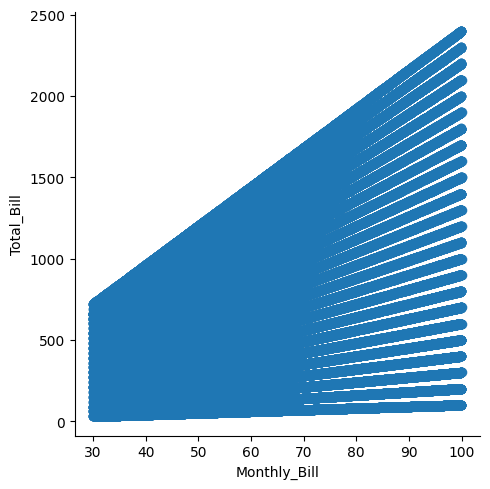

In [28]:
# Relationship between Monthly Charges and Total Charges
sns.lmplot(data=churn_data, x='Monthly_Bill', y='Total_Bill', fit_reg=False)

total Charges increase as Monthly Charges increase - as expected

<Axes: >

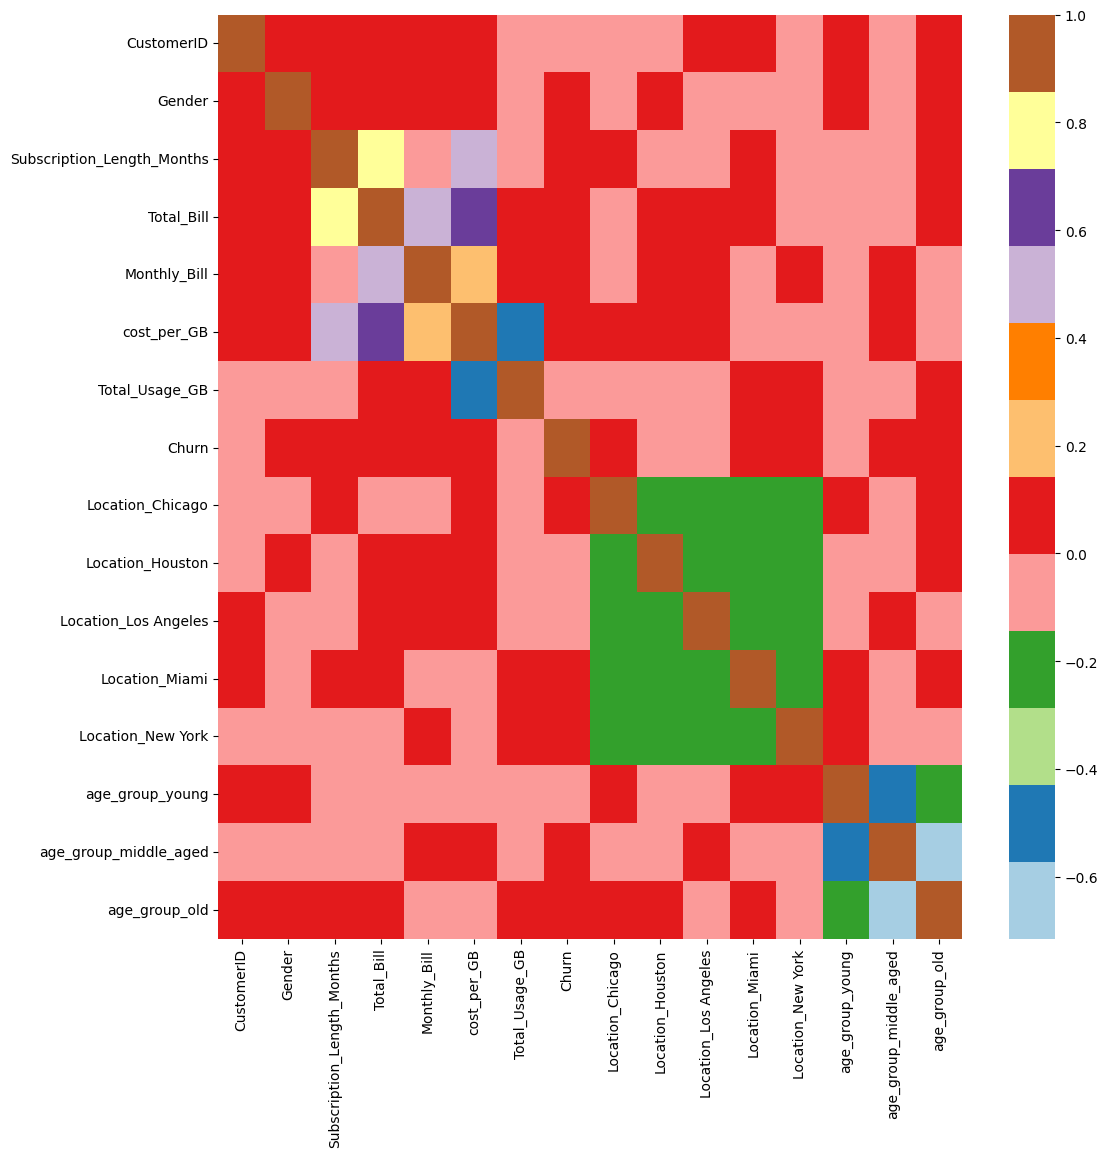

In [32]:
# Heatmap
plt.figure(figsize=(12,12))
sns.heatmap(churn_data.corr(), cmap="Paired")

In [34]:
# save processed data
churn_data.to_csv('/content/drive/MyDrive/MY_dataset/churn_data_processed.csv')

# MODEL BUILD

In [37]:
# read saved data
df=pd.read_csv("/content/drive/MyDrive/MY_dataset/churn_data_processed.csv")
df.head()

,Unnamed: 0,CustomerID,Gender,Subscription_Length_Months,Total_Bill,Monthly_Bill,cost_per_GB,Total_Usage_GB,Churn,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,age_group_young,age_group_middle_aged,age_group_old
0,0,1,1,17,1247.12,73.36,5.284407,236,0,0,0,1,0,0,0,0,1
1,1,2,0,1,48.76,48.76,0.283488,172,0,0,0,0,0,1,0,0,1
2,2,3,0,5,427.35,85.47,0.929022,460,0,0,0,1,0,0,1,0,0
3,3,4,0,3,293.82,97.94,0.989293,297,1,0,0,0,1,0,0,1,0
4,4,5,0,19,1104.66,58.14,4.152857,266,0,0,0,0,1,0,0,1,0


In [39]:
df=df.drop('Unnamed: 0', axis=1)

In [40]:
x = df.drop('Churn', axis=1)
y = df['Churn']

In [43]:
# Train Test Split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

### Decision Tree Classifier

In [44]:
model_dt=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)

In [45]:
model_dt.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [46]:
y_pred=model_dt.predict(x_test)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [47]:
model_dt.score(x_test,y_test)

0.50315

In [56]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.50      0.77      0.61     10058
           1       0.50      0.24      0.32      9942

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.46     20000
weighted avg       0.50      0.50      0.47     20000



### Random Forest Classifier

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
model_rf=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)

In [59]:
model_rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [60]:
y_pred=model_rf.predict(x_test)

In [61]:
model_rf.score(x_test,y_test)

0.4991

In [62]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.50      0.71      0.59     10058
           1       0.49      0.29      0.36      9942

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.50      0.50      0.48     20000



### Performing PCA

In [64]:
# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(0.9)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_

In [65]:
model=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)

In [68]:
model.fit(x_train_pca,y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [72]:
y_predict_pca = model.predict(x_test_pca)

In [73]:
model_score_r_pca = model.score(x_test_pca, y_test)

In [74]:
print(model_score_r_pca)
print(metrics.classification_report(y_test, y_predict_pca))

0.5052
              precision    recall  f1-score   support

           0       0.50      0.86      0.64     10058
           1       0.51      0.14      0.22      9942

    accuracy                           0.51     20000
   macro avg       0.51      0.50      0.43     20000
weighted avg       0.51      0.51      0.43     20000



### ANN in TensorFlow

In [76]:
import tensorflow as tf
from tensorflow import keras

In [77]:
x_train.shape

(80000, 15)

In [78]:
model = keras.Sequential([
    keras.layers.Dense(20, input_shape=(15,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [79]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [80]:
model.fit(x_train, y_train, epochs=20)

Epoch 1/20
2500/2500 [==============================] - 9s 3ms/step - loss: 41.9184 - accuracy: 0.4998
Epoch 2/20
2500/2500 [==============================] - 5s 2ms/step - loss: 13.1331 - accuracy: 0.5006
Epoch 3/20
2500/2500 [==============================] - 5s 2ms/step - loss: 11.3450 - accuracy: 0.5010
Epoch 4/20
2500/2500 [==============================] - 4s 2ms/step - loss: 9.9807 - accuracy: 0.4980
Epoch 5/20
2500/2500 [==============================] - 4s 2ms/step - loss: 9.8399 - accuracy: 0.4999
Epoch 6/20
2500/2500 [==============================] - 5s 2ms/step - loss: 7.9841 - accuracy: 0.5023
Epoch 7/20
2500/2500 [==============================] - 4s 2ms/step - loss: 8.5273 - accuracy: 0.5001
Epoch 8/20
2500/2500 [==============================] - 4s 2ms/step - loss: 7.3414 - accuracy: 0.4989
Epoch 9/20
2500/2500 [==============================] - 5s 2ms/step - loss: 6.3529 - accuracy: 0.4986
Epoch 10/20
2500/2500 [==============================] - 4s 2ms/step - loss: 5.

In [81]:
model.evaluate(x_test, y_test)

625/625 [==============================] - 5s 6ms/step - loss: 1.3095 - accuracy: 0.4978


[1.3094744682312012, 0.49779999256134033]